In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [70]:
data = pd.read_csv("../data/normalized/train/15_train.csv")

In [71]:
# Drop 'session' and 'timestamp' if they exist
#columns_to_drop = ['session', 'timestamp', "hr_min", "hr_max","temp_range","acc_magnitude_max","eda_range", "hr_range","bvp_range", "temp_min", "temp_max", "bvp_max", "bvp_min", "eda_min", "eda_max", "bvp_std"]
columns_to_drop = ['session', 'timestamp']
df = data.drop(columns=[col for col in columns_to_drop if col in data.columns])

In [74]:
df.head()

,temp_mean,temp_std,temp_min,temp_max,temp_range,acc_magnitude_mean,acc_magnitude_std,acc_magnitude_max,acc_magnitude_min,acc_activity_level,...,hr_mean,hr_std,hr_min,hr_max,hr_range,hr_acc_ratio,hrv_mean_ibi,hrv_rmssd,hrv_sdnn,hrv_pnn50
0,-1.764839,-0.428219,30.11,30.13,0.02,-0.263038,-0.891459,1.153396,0.789809,-0.103618,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.590781,3.079598,30.13,30.67,0.54,0.179989,0.612048,1.731557,-0.634658,-0.103618,...,-0.278761,2.856177,81.00,87.25,6.25,-0.331943,NaN,NaN,NaN,NaN
2,-1.413343,0.495764,30.55,30.73,0.18,-0.001563,-0.052127,1.923208,-1.009171,-0.103618,...,-0.558254,0.365863,78.67,80.75,2.08,-0.556782,NaN,NaN,NaN,NaN
3,-1.504597,-0.174095,30.45,30.53,0.08,-0.273057,-0.682245,1.419211,-0.117029,-0.103618,...,-0.854780,2.109009,73.57,78.25,4.68,-0.778502,NaN,NaN,NaN,NaN
4,-1.357577,1.094706,30.55,30.81,0.26,-0.146298,-0.240467,1.456649,0.017071,-0.103618,...,-1.253563,0.777364,70.38,72.92,2.54,-1.206230,NaN,NaN,NaN,NaN


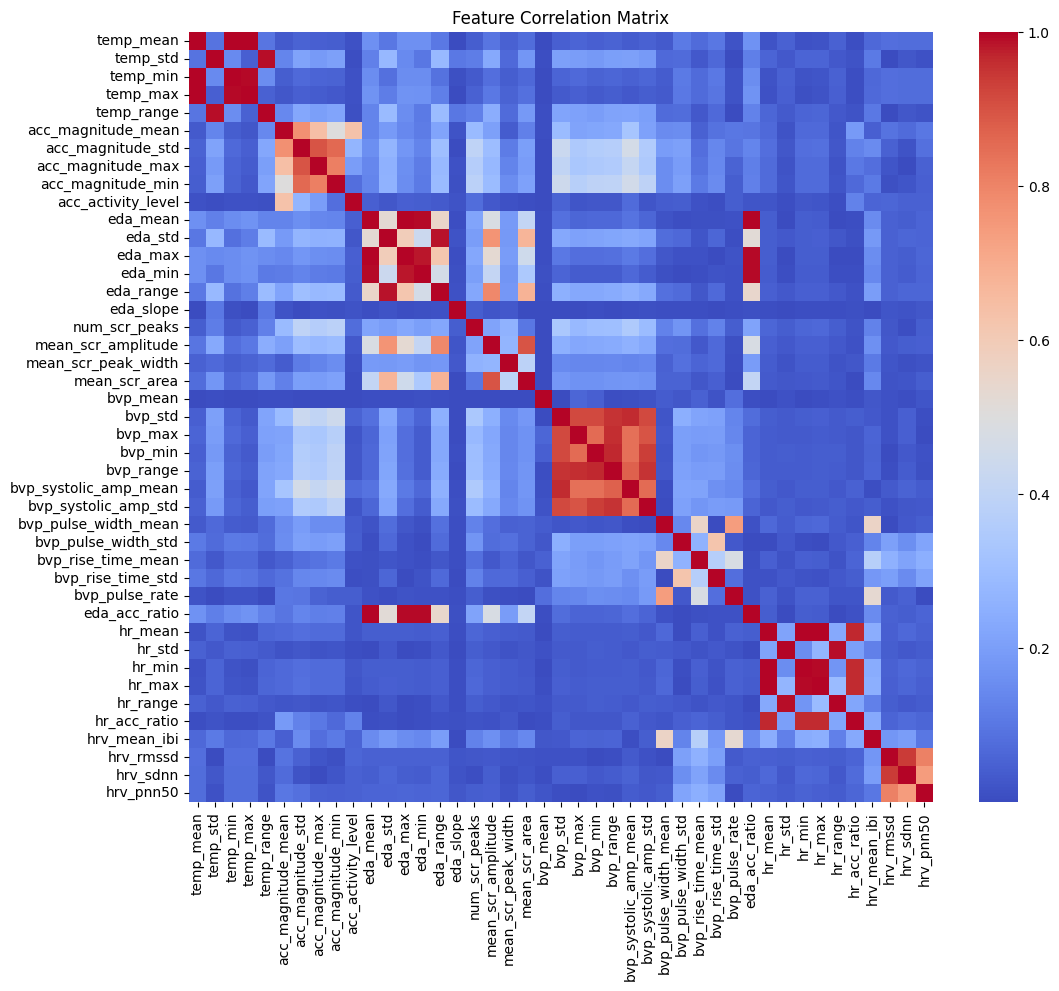

Highly correlated feature pairs (> 0.9):
temp_min and temp_mean: 1.00
temp_max and temp_mean: 1.00
temp_max and temp_min: 0.99
temp_range and temp_std: 0.99
eda_max and eda_mean: 1.00
eda_min and eda_mean: 0.99
eda_min and eda_max: 0.98
eda_range and eda_std: 0.98
bvp_max and bvp_std: 0.92
bvp_min and bvp_std: 0.92
bvp_range and bvp_std: 0.95
bvp_range and bvp_max: 0.96
bvp_range and bvp_min: 0.97
bvp_systolic_amp_mean and bvp_std: 0.96
bvp_systolic_amp_std and bvp_std: 0.91
bvp_systolic_amp_std and bvp_min: 0.94
bvp_systolic_amp_std and bvp_range: 0.95
eda_acc_ratio and eda_mean: 1.00
eda_acc_ratio and eda_max: 0.99
eda_acc_ratio and eda_min: 0.99
hr_min and hr_mean: 1.00
hr_max and hr_mean: 1.00
hr_max and hr_min: 0.99
hr_range and hr_std: 0.99
hr_acc_ratio and hr_mean: 0.97
hr_acc_ratio and hr_min: 0.96
hr_acc_ratio and hr_max: 0.96
hrv_sdnn and hrv_rmssd: 0.94


In [73]:

# Let's say df is your preprocessed (normalized) data
correlation_matrix = df.corr().abs()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# Find highly correlated features
high_corr_pairs = [
    (i, j, correlation_matrix.iloc[i, j])
    for i in range(len(correlation_matrix.columns))
    for j in range(i)
    if correlation_matrix.iloc[i, j] > 0.9
]

print("Highly correlated feature pairs (> 0.9):")
for i, j, corr in high_corr_pairs:
    print(f"{correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}: {corr:.2f}")
